In [1]:
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt 
from plot_function import *
from itertools import cycle
from pathlib import Path
from datetime import date

In [2]:
connection = sqlite3.connect('./sample_database.db')
c = connection.cursor()

# Extract data from database

In [3]:
TC_fit = pd.read_sql_query("""SELECT * FROM tc_fit_results""", con=connection)
HB_fit = pd.read_sql_query("""SELECT * FROM hb_fit_results""", con=connection)
amp_sweeps = pd.read_sql_query("""SELECT * FROM amp_sweep_info""", con=connection)
solvents = pd.read_sql_query("SELECT * FROM solvent_infos", con=connection)
dilu = pd.read_sql_query("""SELECT sample_prep_info.*, 
                                   dilution_series.dilution_serie
                            FROM sample_prep_info
                            LEFT JOIN dilution_series USING (sample_ID)
                         """, con=connection)
frq_sweeps = pd.read_sql("select * from frq_sweep_info", con=connection)
flow_curves = pd.read_sql("select * from flow_curves", con=connection)

In [4]:
HB_fit.head()

,sample_ID,temperature,yield_stress_HB,err_yield_stress_HB,K,err_K,n,err_n,AIC
0,20210716001,20,0.373407,0.011315,13.225142,0.156590,0.579168,0.003600,-575.798239
1,20210716006,20,9.300611,0.125074,26.481206,0.452363,0.539478,0.004281,-415.818729
2,20210716008,20,69.933281,0.772715,96.071475,1.883946,0.486033,0.004550,-437.407426
3,20210716006,50,9.126988,0.061589,12.328694,0.134187,0.531477,0.002428,-457.453918
4,20210907006,20,25.997643,0.259329,49.849989,0.761706,0.527476,0.003509,-556.248754


# Plot the concentration sweep

In [5]:
flow_curves = pd.merge(left=flow_curves, right=dilu, how='left', on=['sample_ID'])
flow_curves_concentration_sweep = flow_curves[flow_curves.dilution_serie == 'carbopol~974p~in~propylenglycol']


In [6]:
np.sort(flow_curves_concentration_sweep.w_percent.unique())

array([1.3 , 1.5 , 1.7 , 1.75, 1.78, 1.8 , 1.85, 1.9 , 2.  , 2.7 , 3.  ])

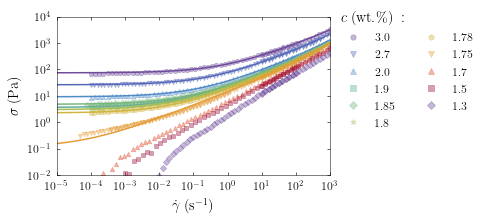

In [7]:
fig, ax, color, marker = create_plot()
# select 20°C
df20 = flow_curves_concentration_sweep[flow_curves_concentration_sweep.temperature == 20]
df20 = df20.sort_values('w_percent', ascending=False)
x = np.logspace(-5, 3, 30)
for c, dfh in df20.groupby('w_percent', sort=False):
    col = next(color)
    TC = TC_fit[(TC_fit.sample_ID == list(dfh.sample_ID)[0]) & (TC_fit.temperature == 20)]
    ax.loglog(dfh.shear_rate, dfh.shear_stress, c=col, mfc=col, alpha=0.4, marker=next(marker), label=f'${c}$')
    if len(TC > 0):
        ax.loglog(x, 
                  np.array(TC.yield_stress_TC)+ np.array(TC.viscinf) * x + 
                  np.array(TC.yield_stress_TC) * (x / float(TC.caract_shear_rate))**0.5 ,
                  c=col, ls='-', marker='', lw=1.5)
    
ax.legend(title='$c~(\mathrm{wt.}\%)~:$', bbox_to_anchor=(1, 1.1), ncol=2)._legend_box.align='left'
ax.set(xlim=(1e-5, 1e3), ylim=(1e-2, 1e4))
ax.set(xlabel='$\dot{\gamma}~(\mathrm{s}^{-1})$', 
       ylabel='$\sigma~\mathrm{(Pa)}$', 
      xticks=[1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1000], 
      yticks=[0.01, 0.1, 1, 10, 100, 1000, 10000])
fig.savefig('./figures/concentration_sweep.svg')

# only liquid samples

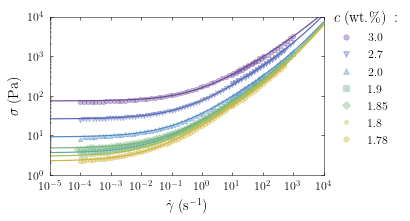

In [19]:
fig, ax, color, marker = create_plot()
# select 20°C
df20 = flow_curves_concentration_sweep[flow_curves_concentration_sweep.temperature == 20]
df20 = df20.sort_values('w_percent', ascending=False)
x = np.logspace(-5, 4, 30)
for c, dfh in df20.groupby('w_percent', sort=False):
    if c > 1.77:
        col = next(color)
        TC = TC_fit[(TC_fit.sample_ID == list(dfh.sample_ID)[0]) & (TC_fit.temperature == 20)]
        
        if len(TC > 0):
            ax.loglog(x, 
                      np.array(TC.yield_stress_TC)+ np.array(TC.viscinf) * x + 
                      np.array(TC.yield_stress_TC) * (x / float(TC.caract_shear_rate))**0.5 ,
                      c=col, ls='-', marker='', lw=1.2)
        ax.loglog(dfh.shear_rate, dfh.shear_stress, c=col, mfc=col, alpha=0.4, marker=next(marker), label=f'${c}$')
    
ax.legend(title='$c~(\mathrm{wt.}\%)~:$', bbox_to_anchor=(1, 1.1), ncol=1)._legend_box.align='left'
ax.set(xlim=(1e-5, 1e3), ylim=(1, 1e4))
ax.set(xlabel='$\dot{\gamma}~(\mathrm{s}^{-1})$', 
       ylabel='$\sigma~\mathrm{(Pa)}$', 
      xticks=[1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
      yticks=[1, 10, 100, 1000, 10000])
fig.savefig('./figures/VT_figures/concentration_sweep_only_ys.svg')

# TC Parameters for concentration sweep

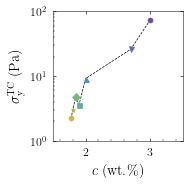

In [23]:
TC_fit_merge = pd.merge(left=TC_fit, right=dilu, how='left', on=['sample_ID'])

TC_dilu = TC_fit_merge[(TC_fit_merge.dilution_serie == 'carbopol~974p~in~propylenglycol') & (TC_fit_merge.temperature == 20)
                      & (TC_fit_merge.w_percent > 1.77)]
TC_dilu = TC_dilu.sort_values('w_percent', ascending=False)

fig, ax, color, marker = create_plot(figsize=(3, 3))

ax.plot(TC_dilu.w_percent, TC_dilu.yield_stress_TC, ls='--', marker='', c='k')
for i, dfh in TC_dilu.iterrows():
    c = next(color)
    ax.plot(dfh.w_percent, dfh.yield_stress_TC, c=c, mfc=c, marker=next(marker), ms=5)

ax.set(xlim=(1.5, 3.5), ylim=(1, 100), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\sigma_\mathrm{y}^\mathrm{TC}~\mathrm{(Pa)}$'
      )

fig.savefig('./figures/VT_figures/concentration_sweep_parameters/ys.svg')

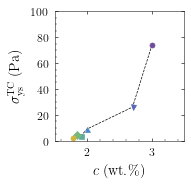

In [24]:
fig, ax, color, marker = create_plot(figsize=(3,3))

ax.plot(TC_dilu.w_percent, TC_dilu.yield_stress_TC, ls='--', marker='', c='k')
for i, dfh in TC_dilu.iterrows():
    c = next(color)
    ax.plot(dfh.w_percent, dfh.yield_stress_TC, c=c, mfc=c, marker=next(marker), ms=5)

ax.set(xlim=(1.5, 3.5), ylim=(0, 100), 
       #yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\sigma_\mathrm{ys}^\mathrm{TC}~\mathrm{(Pa)}$'
      )

fig.savefig('./figures/concentration_sweep_parameters/ys.png', dpi = 300)

In [11]:
TC_dilu

,sample_ID,temperature,yield_stress_TC,err_yield_stress_TC,caract_shear_rate,err_caract_shear_rate,viscinf,err_viscinf,crit_strain_TC,err_crit_strain_TC,AIC,solvent,microgel_type,w_percent,dilution_serie
2,20210716008,20,73.968630,76.037272,0.758362,0.045615,0.398315,0.061344,0.004084,0.005072,0.098983,propylenglycol,carbopol~974p,3.00,carbopol~974p~in~propylenglycol
4,20210907006,20,26.012211,0.280136,0.278778,0.018522,0.600169,0.033926,0.006432,0.000860,-49.462675,propylenglycol,carbopol~974p,2.70,carbopol~974p~in~propylenglycol
1,20210716006,20,9.124571,27.725465,0.119434,0.004493,0.468318,0.008372,0.006130,0.018966,-202.542344,propylenglycol,carbopol~974p,2.00,carbopol~974p~in~propylenglycol
27,20210716005,20,3.604169,0.119607,0.032318,0.001090,0.475512,0.004545,0.004264,0.000326,-282.145086,propylenglycol,carbopol~974p,1.90,carbopol~974p~in~propylenglycol
6,20210907005,20,4.746656,20.326391,0.057685,0.001599,0.456668,0.006872,0.005550,0.024003,-288.315233,propylenglycol,carbopol~974p,1.85,carbopol~974p~in~propylenglycol
13,20210716004,20,2.966881,0.176691,0.026528,0.000934,0.512447,0.006528,0.004582,0.000493,-283.644984,propylenglycol,carbopol~974p,1.80,carbopol~974p~in~propylenglycol
5,20210907004,20,2.238038,16.598882,0.021492,0.000590,0.450764,0.004034,0.004329,0.032263,-340.996907,propylenglycol,carbopol~974p,1.78,carbopol~974p~in~propylenglycol


In [12]:
TC_dilu.loc[:, ['w_percent', 'viscinf', 'caract_shear_rate', 'yield_stress_TC', 'AIC']]

,w_percent,viscinf,caract_shear_rate,yield_stress_TC,AIC
2,3.00,0.398315,0.758362,73.968630,0.098983
4,2.70,0.600169,0.278778,26.012211,-49.462675
1,2.00,0.468318,0.119434,9.124571,-202.542344
27,1.90,0.475512,0.032318,3.604169,-282.145086
6,1.85,0.456668,0.057685,4.746656,-288.315233
13,1.80,0.512447,0.026528,2.966881,-283.644984
5,1.78,0.450764,0.021492,2.238038,-340.996907


In [13]:
HB_fit_merge = pd.merge(left=HB_fit, right=dilu, how='left', on=['sample_ID'])

HB_dilu = HB_fit_merge[(HB_fit_merge.dilution_serie == 'carbopol~974p~in~propylenglycol') & (HB_fit_merge.temperature == 20)]
HB_dilu = HB_dilu.sort_values('w_percent', ascending=False)

In [14]:
HB_dilu.loc[:, ['w_percent', 'K', 'n', 'yield_stress_HB', 'AIC']]

,w_percent,K,n,yield_stress_HB,AIC
2,3.00,96.071475,0.486033,69.933281,-437.407426
4,2.70,49.849989,0.527476,25.997643,-556.248754
1,2.00,26.481206,0.539478,9.300611,-415.818729
27,1.90,19.484677,0.560191,3.994301,-408.602547
6,1.85,20.709460,0.534330,4.795529,-419.814654
13,1.80,18.421148,0.551376,3.201410,-378.654697
5,1.78,15.763149,0.548393,2.382766,-399.781862
0,1.75,13.225142,0.579168,0.373407,-575.798239


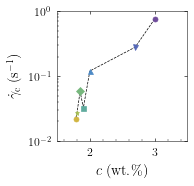

In [25]:

fig, ax, color, marker = create_plot(figsize=(3,3))
ax.plot(TC_dilu.w_percent, TC_dilu.caract_shear_rate, ls='--', marker='', c='k')
for i, dfh in TC_dilu.iterrows():
    c = next(color)
    ax.plot(dfh.w_percent, dfh.caract_shear_rate, c=c, mfc=c, marker=next(marker), ms=5)

ax.set(xlim=(1.5, 3.5), ylim=(1e-2, 1), 
       
       yscale='log',
       yticks=[1e-2, 0.1, 1],
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\dot{\gamma}_\mathrm{c}~\mathrm{(s^{-1})}$'
      )
fig.savefig('./figures/VT_figures/concentration_sweep_parameters/gammadotcrit.svg')

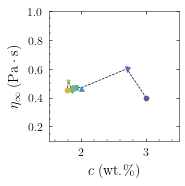

In [26]:

fig, ax, color, marker = create_plot(figsize=(3,3))
ax.plot(TC_dilu.w_percent, TC_dilu.viscinf, ls='--', marker='', c='k')
for i, dfh in TC_dilu.iterrows():
    c = next(color)
    ax.plot(dfh.w_percent, dfh.viscinf, c=c, mfc=c, marker=next(marker), ms=5)

ax.set(xlim=(1.5, 3.5), ylim=(0.1, 1), 
       #yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\eta_\infty~\mathrm{(Pa \cdot s)}$'
      )

fig.savefig('./figures/VT_figures/concentration_sweep_parameters/viscinf.svg')

# Effect of temperature 

In [36]:
flow_curves = pd.read_sql_query("""
                    SELECT flow_curves.*, frq_sweep_info.elastic_modulus,
                    dilution_series.*, sample_prep_info.*, solvent_infos.*, tc_fit_results.*
                    FROM flow_curves
                    LEFT JOIN frq_sweep_info
                    ON ((flow_curves.sample_ID = frq_sweep_info.sample_ID) AND (flow_curves.temperature = frq_sweep_info.temperature))
                    LEFT JOIN dilution_series 
                    ON (flow_curves.sample_ID = dilution_series.sample_ID)
                    LEFT JOIN sample_prep_info
                    ON (flow_curves.sample_ID = sample_prep_info.sample_ID)
                    LEFT JOIN tc_fit_results
                    ON ((flow_curves.sample_ID = tc_fit_results.sample_ID) AND ((flow_curves.temperature = tc_fit_results.temperature)))
                    LEFT JOIN solvent_infos
                    ON ((sample_prep_info.solvent = solvent_infos.solvent) AND (flow_curves.temperature = solvent_infos.temperature))
                    WHERE dilution_serie = 'carbopol~974p~in~propylenglycol'
                  """, con=connection)

In [37]:
flow_curves = flow_curves.loc[:, ~flow_curves.columns.duplicated(keep='first')]
flow_curves_T = flow_curves[flow_curves.w_percent == 1.9]

dict_colors = {10: '#3a4cbf', 15: '#6281e9', 20: '#629ae9',
               25: '#b7cff7', 30:'#dbdbdb', 35: '#f3c3ab', 
               40: '#f39779', 45: '#db5e4a', 50: '#b30426'
                }

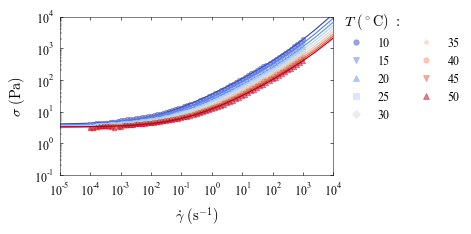

In [56]:
fig, ax, color, marker = create_plot()

x = np.logspace(-6, 7, 30)


for T, dfg in flow_curves_T.groupby('temperature'):
    ax.loglog(dfg.shear_rate,
                  dfg.shear_stress, c=dict_colors[T], mfc=dict_colors[T], marker=next(marker),
                  alpha=0.5, label=f'{T}')
    ax.loglog(x, 
              list(dfg.yield_stress_TC)[0] + list(dfg.yield_stress_TC)[0]*(x/(list(dfg.caract_shear_rate)[0]))**0.5 + list(dfg.viscinf)[0] * x,
              ls='-', marker='', c=dict_colors[T], lw=1.2)
ax.legend(title='$T~(^\circ \mathrm{C})~:$', bbox_to_anchor=(1, 1.1), ncol=2)._legend_box.align='left'
ax.set(ylabel='$\sigma~\mathrm{(Pa)}$', 
      xlabel='$\dot{\gamma}~(\mathrm{s}^{-1})$', 
      xlim=(1e-5, 1e4), ylim=(0.1, 1e4), 
      xticks=[1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
      yticks=[0.1, 1, 10, 100, 1000, 10000]);
fig.savefig('./figures/VT_figures/T_dependency.svg', bbox_inches='tight')

In [71]:
flow_curves_T.groupby('temperature', as_index=False).agg('mean')

,temperature,sample_ID,shear_stress,viscosity,shear_rate,time,elastic_modulus,w_percent,solvent_viscosity,yield_stress_TC,err_yield_stress_TC,caract_shear_rate,err_caract_shear_rate,viscinf,err_viscinf,crit_strain_TC,err_crit_strain_TC,AIC
0,10,2.021072e+10,192.177763,3025.296239,68.480512,915.904755,75.374888,1.9,0.102050,4.010954,0.375294,0.017260,0.000677,0.921989,0.006930,0.003968,0.000557,-255.600183
1,15,2.021072e+10,148.128213,2875.468746,68.480493,915.904623,48.807142,1.9,0.075337,3.769396,0.196972,0.024065,0.000845,0.654936,0.005352,0.004181,0.000399,-274.425703
2,20,2.021072e+10,118.271871,2723.016381,68.480495,915.904831,72.633333,1.9,0.054799,3.604169,0.119607,0.032318,0.001090,0.475512,0.004545,0.004264,0.000326,-282.145086
3,25,2.021072e+10,97.165080,2512.756917,68.480537,915.904803,40.139006,1.9,0.040253,3.447727,0.243380,0.041645,0.001538,0.358097,0.004449,0.004325,0.000519,-271.502554
4,30,2.021072e+10,81.076607,2414.814753,68.480497,915.905761,36.587276,1.9,0.030566,3.340430,0.101961,0.054017,0.001942,0.275546,0.003916,0.004456,0.000360,-277.019900
5,35,2.021072e+10,69.044520,2290.917447,68.480496,915.904113,35.258209,1.9,0.023787,3.226469,0.144022,0.067334,0.002483,0.217420,0.003655,0.004537,0.000446,-275.589420
6,40,2.021072e+10,59.593098,2246.051638,68.480498,915.904352,32.173095,1.9,0.018617,3.170269,0.088356,0.086056,0.003153,0.177509,0.003342,0.004818,0.000402,-277.968557
7,45,2.021072e+10,55.509894,1234.073378,71.501686,837.530819,34.853767,1.9,0.015026,3.301242,0.188417,0.114974,0.004279,0.147886,0.003122,0.005151,0.000594,-268.624677
8,50,2.021072e+10,47.454320,2260.493693,68.480497,915.905070,31.910160,1.9,0.012257,3.277103,0.163287,0.141747,0.004967,0.124429,0.002886,0.005382,0.000582,-282.958644


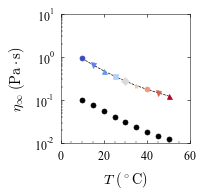

In [87]:
fig, ax, color, marker = create_plot(figsize=(3,3))
ax.plot(flow_curves_T.temperature, flow_curves_T.viscinf, ls='--', marker='', c='k')
for _, dfh in flow_curves_T.groupby('temperature', as_index=False).agg('mean').iterrows():
    T = int(dfh.temperature)
    ax.plot(T, dfh.viscinf, c=dict_colors[T], mfc=dict_colors[T], marker=next(marker), ms=5)
    ax.plot(T, dfh.solvent_viscosity, c='k', mfc='k', marker='o', ms=5, ls='-')


ax.set(xlim=(0, 60), ylim=(0.01, 10), 
       yscale='log',
       xlabel='$T~(^\circ \mathrm{C})$',
       ylabel='$\eta_\infty~\mathrm{(Pa \cdot s)}$'
      )

fig.savefig('./figures/VT_figures/T_sweep_parameters/viscinf.svg')

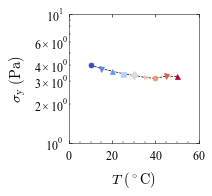

In [92]:
fig, ax, color, marker = create_plot(figsize=(3,3))
ax.plot(flow_curves_T.temperature, flow_curves_T.yield_stress_TC, ls='--', marker='', c='k')
for _, dfh in flow_curves_T.groupby('temperature', as_index=False).agg('mean').iterrows():
    T = int(dfh.temperature)
    ax.plot(T, dfh.yield_stress_TC, c=dict_colors[T], mfc=dict_colors[T], marker=next(marker), ms=5)


ax.set(xlim=(0, 60), ylim=(1, 10), 
       yscale='log',
       xlabel='$T~(^\circ \mathrm{C})$',
       ylabel='$\sigma_\mathrm{y}~\mathrm{(Pa)}$'
      )

fig.savefig('./figures/VT_figures/T_sweep_parameters/ys.svg')

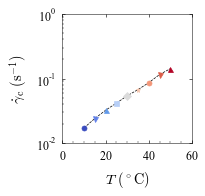

In [94]:
fig, ax, color, marker = create_plot(figsize=(3,3))
ax.plot(flow_curves_T.temperature, flow_curves_T.caract_shear_rate, ls='--', marker='', c='k')
for _, dfh in flow_curves_T.groupby('temperature', as_index=False).agg('mean').iterrows():
    T = int(dfh.temperature)
    ax.plot(T, dfh.caract_shear_rate, c=dict_colors[T], mfc=dict_colors[T], marker=next(marker), ms=5)


ax.set(xlim=(0, 60), ylim=(0.01, 1), 
       yscale='log',
       xlabel='$T~(^\circ \mathrm{C})$',
       ylabel='$\dot{\gamma}_\mathrm{c}~(\mathrm{s}^{-1})$'
      )

fig.savefig('./figures/VT_figures/T_sweep_parameters/gammadotc.svg')

In [61]:
flow_curves_T.groupby('temperature').agg('mean')

,sample_ID,shear_stress,viscosity,shear_rate,time,elastic_modulus,w_percent,solvent_viscosity,yield_stress_TC,err_yield_stress_TC,caract_shear_rate,err_caract_shear_rate,viscinf,err_viscinf,crit_strain_TC,err_crit_strain_TC,AIC
temperature,,,,,,,,,,,,,,,,,
10,2.021072e+10,192.177763,3025.296239,68.480512,915.904755,75.374888,1.9,0.102050,4.010954,0.375294,0.017260,0.000677,0.921989,0.006930,0.003968,0.000557,-255.600183
15,2.021072e+10,148.128213,2875.468746,68.480493,915.904623,48.807142,1.9,0.075337,3.769396,0.196972,0.024065,0.000845,0.654936,0.005352,0.004181,0.000399,-274.425703
20,2.021072e+10,118.271871,2723.016381,68.480495,915.904831,72.633333,1.9,0.054799,3.604169,0.119607,0.032318,0.001090,0.475512,0.004545,0.004264,0.000326,-282.145086
25,2.021072e+10,97.165080,2512.756917,68.480537,915.904803,40.139006,1.9,0.040253,3.447727,0.243380,0.041645,0.001538,0.358097,0.004449,0.004325,0.000519,-271.502554
30,2.021072e+10,81.076607,2414.814753,68.480497,915.905761,36.587276,1.9,0.030566,3.340430,0.101961,0.054017,0.001942,0.275546,0.003916,0.004456,0.000360,-277.019900
35,2.021072e+10,69.044520,2290.917447,68.480496,915.904113,35.258209,1.9,0.023787,3.226469,0.144022,0.067334,0.002483,0.217420,0.003655,0.004537,0.000446,-275.589420
40,2.021072e+10,59.593098,2246.051638,68.480498,915.904352,32.173095,1.9,0.018617,3.170269,0.088356,0.086056,0.003153,0.177509,0.003342,0.004818,0.000402,-277.968557
45,2.021072e+10,55.509894,1234.073378,71.501686,837.530819,34.853767,1.9,0.015026,3.301242,0.188417,0.114974,0.004279,0.147886,0.003122,0.005151,0.000594,-268.624677
50,2.021072e+10,47.454320,2260.493693,68.480497,915.905070,31.910160,1.9,0.012257,3.277103,0.163287,0.141747,0.004967,0.124429,0.002886,0.005382,0.000582,-282.958644
